# [Chapter 12] Predicting online shopping purchase intent using using CART and RF

## **[DSLC stages]**: Analysis


In this document, you will find the PCS workflow and code for fitting the CART and RF algorithms to the online shopping data.


The following code sets up the libraries and creates cleaned and pre-processed training, validation and test data that we will use in this document.

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn import metrics 
from joblib import Parallel, delayed
from itertools import product
import matplotlib.pyplot as plt

# define all of the objects we need by running the preparation script
%run functions/prepare_shopping_data.py

pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 500
pd.options.display.max_rows = 100

Note that unlike the R versions, the scikit-learn versions of CART and RF cannot accept non-numeric (categorical) variables.

In [2]:
# look at all variables defined in our space
%who

DecisionTreeClassifier	 LinearRegression	 LogisticRegression	 Parallel	 RandomForestClassifier	 delayed	 ff	 go	 metrics	 
np	 pd	 permutation_importance	 plot_tree	 plt	 preprocess_shopping_data	 product	 px	 shopping_orig	 
shopping_test	 shopping_test_preprocessed	 shopping_train	 shopping_train_preprocessed	 shopping_train_preprocessed_nodummy	 shopping_val	 shopping_val_preprocessed	 



## A manual CART demonstration

In this section, we will demonstrate one example of manually compute the first CART split for a small sample of 30 training sessions.

First, let's create the sample of 30 training sessions (8 that ended with a purchase and 22 that did not).

In [3]:
# extract the index position of each row to include in the sample to match the R version
sample_index = [6529, 1278, 3304, 604, 287, 6780, 1799, 2088,
                7188, 4690, 3892, 3347, 581, 6910, 2108, 5081, 
                1626, 2487, 3931, 2078, 6192, 6527, 5814, 1534, 
                7205, 6356, 5043, 1973, 694, 2258]
# since python is 0-indexed, we need to subtract 1 from each index
sample_index = [x - 1 for x in sample_index]

shopping_train_sample = shopping_train.iloc[sample_index, :]
shopping_train_sample = preprocess_shopping_data(shopping_train_sample)
shopping_train_sample = shopping_train_sample[['product_related_duration', 'exit_rates', 'purchase']]

shopping_train_sample

product_related_duration  exit_rates  purchase
0                  14.103333    0.025000      True
1                  32.596389    0.002439      True
2                  34.310076    0.009550      True
3                   8.987123    0.011281      True
4                  19.388889    0.009375      True
5                   8.440873    0.009091      True
6                  20.213492    0.020968      True
7                  14.961111    0.017017      True
8                  26.185397    0.010638     False
9                  34.394047    0.011934     False
10                  4.212500    0.016667     False
11                  0.665833    0.050000     False
12                  3.716667    0.023529     False
13                 37.088148    0.021516     False
14                 41.713611    0.011147     False
15                  4.538889    0.036667     False
16                  3.686806    0.012698     False
17                  9.138889    0.031373     False
18                  4.725000    0.010526     False
19                 19.577778    0.040833     False
20                 32.153094    0.025063     False
21                 20.575000    0.020690     False
22                  4.875000    0.021250     False
23                 17.732500    0.019048     False
24                 52.886840    0.009122     False
25                  6.570833    0.015385     False
26                  2.844444    0.026667     False
27                  2.087500    0.033333     False
28                  0.583333    0.066667     False
29                 26.144167    0.021839     False

Then, we can create a DataFrame with the set of potential split questions

In [4]:
questions = pd.DataFrame({
    'variable': ['exit_rates', 'exit_rates', 'exit_rates', 'product_related_duration', 'product_related_duration', 'product_related_duration'],
    'value': [0.010, 0.025, 0.031, 8.41, 3.85, 15.92]
})

questions


variable   value
0                exit_rates   0.010
1                exit_rates   0.025
2                exit_rates   0.031
3  product_related_duration   8.410
4  product_related_duration   3.850
5  product_related_duration  15.920


And define a function for computing the Gini split measure for each split option.


In [5]:
def get_gini(variable, value):
    yes = shopping_train_sample[variable] < value
    purchase = shopping_train_sample['purchase'].astype(float)
    
    gini_yes = 1 - (sum(purchase[yes]) / sum(yes))**2 - (1 - sum(purchase[yes]) / sum(yes))**2
    gini_no = 1 - (sum(purchase[~yes]) / sum(~yes))**2 - (1 - sum(purchase[~yes]) / sum(~yes))**2
    
    gini = sum(yes) / len(yes) * gini_yes + sum(~yes) / len(yes) * gini_no
    
    return pd.DataFrame({'split': [f"{variable} < {value}"], 'gini': [round(gini, 2)]})



Then we can apply this function to the set of potential split questions

In [6]:
result = [get_gini(variable, value) for variable, value in zip(questions['variable'], questions['value'])]
result_df = pd.concat(result).reset_index(drop=True)
result_df


split  gini
0                 exit_rates < 0.01  0.28
1                exit_rates < 0.025  0.37
2                exit_rates < 0.031  0.36
3   product_related_duration < 8.41  0.31
4   product_related_duration < 3.85  0.36
5  product_related_duration < 15.92  0.39


and we see that the split question, `exit_rates < 0.01` yields the lowest variance for these 30 training sessions, and so this is the threshold rule that we will use to define the first split.


Fortunately, you wouldn't have to do this manually yourself, since the scikit-learn `DecisionTreeClassifier()` class will do it for you (although it will consider a much broader range of split options than the set that we considered above). Below, you can see that the `DecisionTreeClassifier()` function similarly identifies `exit_rates < 0.01` as the best split option (the first split).


[Text(0.36363636363636365, 0.9166666666666666, 'x[1] <= 0.01\ngini = 0.391\nsamples = 30\nvalue = [22, 8]'),
 Text(0.18181818181818182, 0.75, 'x[0] <= 43.598\ngini = 0.32\nsamples = 5\nvalue = [1, 4]'),
 Text(0.09090909090909091, 0.5833333333333334, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(0.2727272727272727, 0.5833333333333334, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.5454545454545454, 0.75, 'x[0] <= 7.779\ngini = 0.269\nsamples = 25\nvalue = [21, 4]'),
 Text(0.45454545454545453, 0.5833333333333334, 'gini = 0.0\nsamples = 11\nvalue = [11, 0]'),
 Text(0.6363636363636364, 0.5833333333333334, 'x[0] <= 16.347\ngini = 0.408\nsamples = 14\nvalue = [10, 4]'),
 Text(0.45454545454545453, 0.4166666666666667, 'x[1] <= 0.028\ngini = 0.375\nsamples = 4\nvalue = [1, 3]'),
 Text(0.36363636363636365, 0.25, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(0.5454545454545454, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.8181818181818182, 0.4166666666666667, 'x[0] <= 20

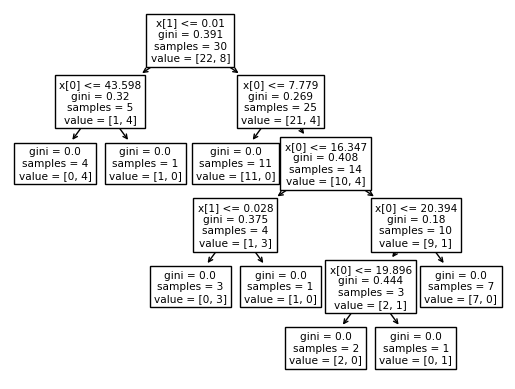

In [7]:
# Create the Decision Tree Classifier
shopping_example_cart = DecisionTreeClassifier()

# Fit the classifier to the training data
shopping_example_cart.fit(shopping_train_sample[['product_related_duration', 'exit_rates']], 
                          shopping_train_sample['purchase'])

# Print the decision tree splits
plot_tree(shopping_example_cart)



## Fitting CART and RF using the entire training set

Below, we fit a CART algorithm using the entire training dataset using all of the available features.

In [8]:
# Create the Decision Tree Classifier with the same default values as R's rpart
cart = DecisionTreeClassifier(min_samples_split=20,
                              max_depth=30)
cart.fit(shopping_train_preprocessed.drop(columns='purchase'),
         shopping_train_preprocessed['purchase'])

# compute validation set predictions (probability)
cart_val_pred = cart.predict_proba(shopping_val_preprocessed.drop(columns='purchase'))
# extract the positive class predictions from cart_val_pred
cart_val_pred = cart_val_pred[:, 1]


We can also fit a RF algorithm using the entire training dataset and all available features using the scikit-learn `RandomForestClassifier()` class.

In [9]:
rf = RandomForestClassifier(random_state=8743)
rf.fit(shopping_train_preprocessed.drop(columns='purchase'),
       shopping_train_preprocessed['purchase'])

# compute validation set predictions (probability)
rf_val_pred = rf.predict_proba(shopping_val_preprocessed.drop(columns='purchase'))
# extract just the positive class prediction from rf_val_pred
rf_val_pred = rf_val_pred[:, 1]


## RF variable importance

To extract the variable importance from the RF fit, you can use the `feature_importances_` attribute of the `RandomForestClassifier()` class.


In [10]:
impurity_importance_df = pd.DataFrame({
    'variable': shopping_train_preprocessed.drop(columns='purchase').columns,
    'importance': rf.feature_importances_
}).sort_values('importance')
impurity_importance_df

variable  importance
13                 month_feb    0.000204
28                 browser_3    0.000559
25   operating_systems_other    0.000579
24       operating_systems_8    0.000875
32                 browser_8    0.000993
52        traffic_type_other    0.001141
33             browser_other    0.001311
26                browser_10    0.001696
31                 browser_6    0.001729
15                month_june    0.001864
46           traffic_type_20    0.002077
40                  region_8    0.002456
43           traffic_type_11    0.002576
50            traffic_type_6    0.002878
49            traffic_type_5    0.002961
44           traffic_type_13    0.003000
23       operating_systems_4    0.003189
30                 browser_5    0.003383
37                  region_5    0.003484
9                special_day    0.003967
14                 month_jul    0.004041
20                 month_sep    0.004291
41                  region_9    0.004420
19                 month_oct    0.004466
42           traffic_type_10    0.004917
48            traffic_type_4    0.005129
29                 browser_4    0.005153
39                  region_7    0.005156
38                  region_6    0.005185
47            traffic_type_3    0.005587
51            traffic_type_8    0.005783
16                 month_mar    0.005877
36                  region_4    0.005986
12                 month_dec    0.006672
34                  region_2    0.006928
17                 month_may    0.007355
22       operating_systems_3    0.007382
35                  region_3    0.009073
27                 browser_2    0.010480
21       operating_systems_2    0.010491
45            traffic_type_2    0.011029
10              visitor_type    0.011478
11                   weekend    0.011706
2              informational    0.019414
18                 month_nov    0.023477
3     informational_duration    0.027701
0             administrative    0.041712
1    administrative_duration    0.057076
6               bounce_rates    0.058607
4            product_related    0.070785
7                 exit_rates    0.082191
5   product_related_duration    0.085928
8                page_values    0.333602

To compute the permutation importance, we can use the `permutation_importance()` function

In [11]:
permutation_importance_df = pd.DataFrame({
    'variable': shopping_train_preprocessed.drop(columns='purchase').columns,
    'importance': permutation_importance(rf, 
                                         shopping_train_preprocessed.drop(columns='purchase'), 
                                         shopping_train_preprocessed['purchase'], 
                                         n_repeats = 10, 
                                         random_state = 0).importances_mean
}).sort_values('importance')
permutation_importance_df

variable  importance
52        traffic_type_other    0.000000
31                 browser_6    0.000000
28                 browser_3    0.000000
25   operating_systems_other    0.000000
13                 month_feb    0.000000
15                month_june    0.000122
9                special_day    0.000203
32                 browser_8    0.000258
26                browser_10    0.000258
37                  region_5    0.000407
33             browser_other    0.000407
46           traffic_type_20    0.000407
23       operating_systems_4    0.000434
30                 browser_5    0.000529
50            traffic_type_6    0.000543
24       operating_systems_8    0.000543
40                  region_8    0.000543
19                 month_oct    0.000705
34                  region_2    0.000719
44           traffic_type_13    0.000719
39                  region_7    0.000827
43           traffic_type_11    0.000895
41                  region_9    0.000909
38                  region_6    0.000936
49            traffic_type_5    0.000936
48            traffic_type_4    0.001004
42           traffic_type_10    0.001356
36                  region_4    0.001356
29                 browser_4    0.001397
12                 month_dec    0.001804
14                 month_jul    0.001818
16                 month_mar    0.001845
51            traffic_type_8    0.001872
20                 month_sep    0.001913
35                  region_3    0.002021
47            traffic_type_3    0.002211
22       operating_systems_3    0.002509
27                 browser_2    0.003296
21       operating_systems_2    0.003432
11                   weekend    0.003500
3     informational_duration    0.005629
2              informational    0.005643
17                 month_may    0.006009
10              visitor_type    0.006172
45            traffic_type_2    0.009753
0             administrative    0.016481
1    administrative_duration    0.019940
4            product_related    0.023264
6               bounce_rates    0.024064
7                 exit_rates    0.025583
5   product_related_duration    0.030236
18                 month_nov    0.033532
8                page_values    0.165111


And we can visualize these importance measures using a bar plot:

In [12]:
px.bar(permutation_importance_df, 
       y='variable', 
       x='importance', 
       orientation='h', 
       title='Permutation Importance',
       height=1000)

In [13]:
px.bar(impurity_importance_df, 
       y='variable', 
       x='importance', 
       orientation='h', 
       title='Impurity Importance',
       height=1000)

Note that these results look slightly different to the R/book version for two reasons:

1. The scikitlearn version we are using here does not accept categorical variables, so we are using the pre-processed version of the data in which all categorical variables have been converted to dummy or numeric variables.

2. The Python implementation of RF uses slightly different default values than the R version.



## A PCS evaluation of the CART and RF fits

And we can then evaluate the predictability and stability of this CART fit!

### Predictability

Let's evaluate the CART fit using the validation set. This will involve generating validation set predictions, which we can then compare to the original logistic regression fit.

First, let's create a version of the original Logistic regression fit

In [14]:
lr = LogisticRegression()
lr.fit(X=shopping_train_preprocessed.drop(columns='purchase'), 
       y=shopping_train_preprocessed['purchase'])
lr_val_pred = lr.predict_proba(shopping_val_preprocessed.drop(columns='purchase'))
lr_val_pred = lr_val_pred[:,1]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Then we can compare the performance of each fit on the validation set:

In [15]:
# compute the accuracy, true positive rate, true negative rate, and AUC for each fit
val_results = []
val_results.append({'model': 'lr',
                    'accuracy': metrics.accuracy_score(shopping_val_preprocessed['purchase'], lr_val_pred > 0.161),
                    'true_positive_rate': metrics.recall_score(shopping_val_preprocessed['purchase'], lr_val_pred > 0.161),
                    'true_negative_rate': metrics.recall_score(shopping_val_preprocessed['purchase'] == False, lr_val_pred <= 0.161),
                    'auc': metrics.roc_auc_score(shopping_val_preprocessed['purchase'], lr_val_pred)})
val_results.append({'model': 'cart',
                    'accuracy': metrics.accuracy_score(shopping_val_preprocessed['purchase'], cart_val_pred > 0.161),
                    'true_positive_rate': metrics.recall_score(shopping_val_preprocessed['purchase'], cart_val_pred > 0.161),
                    'true_negative_rate': metrics.recall_score(shopping_val_preprocessed['purchase'] == False, cart_val_pred <= 0.161),
                    'auc': metrics.roc_auc_score(shopping_val_preprocessed['purchase'], cart_val_pred)})
val_results.append({'model': 'rf',
                    'accuracy': metrics.accuracy_score(shopping_val_preprocessed['purchase'], rf_val_pred > 0.161),
                    'true_positive_rate': metrics.recall_score(shopping_val_preprocessed['purchase'], rf_val_pred > 0.161),
                    'true_negative_rate': metrics.recall_score(shopping_val_preprocessed['purchase'] == False, rf_val_pred <= 0.161),
                    'auc': metrics.roc_auc_score(shopping_val_preprocessed['purchase'], rf_val_pred)})

# convert the results into a data frame
val_results_df = pd.DataFrame(val_results)
val_results_df

model  accuracy  true_positive_rate  true_negative_rate       auc
0    lr  0.832248            0.779006            0.841452  0.896496
1  cart  0.846498            0.754144            0.862464  0.842871
2    rf  0.846906            0.870166            0.842884  0.930767


The RF algorithm has the highest AUC, even though it has slightly lower accuracy and true negative rates than the CART algorithm for the particular 0.161 binary prediction threshold value.



Let's look at an ROC curve for each fit below to see the overall predictive potential across all threshold values.

In [16]:
# compute the ROC curve variables for lr
lr_fpr, lr_tpr, lr_thresholds = metrics.roc_curve(shopping_val_preprocessed['purchase'], lr_val_pred)

# compute the ROC curve variables for cart
cart_fpr, cart_tpr, cart_thresholds = metrics.roc_curve(shopping_val_preprocessed['purchase'], cart_val_pred)

# compute the ROC curve variables for rf
rf_fpr, rf_tpr, rf_thresholds = metrics.roc_curve(shopping_val_preprocessed['purchase'], rf_val_pred)

# create dataframes for each model's ROC curve
roc_lr = pd.DataFrame({
    'False Positive Rate': lr_fpr,
    'True Positive Rate': lr_tpr,
    'Model': 'Logistic Regression'
})

roc_cart = pd.DataFrame({
    'False Positive Rate': cart_fpr,
    'True Positive Rate': cart_tpr,
    'Model': 'CART'
})

roc_rf = pd.DataFrame({
    'False Positive Rate': rf_fpr,
    'True Positive Rate': rf_tpr,
    'Model': 'RF'
})

# concatenate the dataframes
roc_df = pd.concat([roc_rf, roc_cart, roc_lr])

# plot the ROC curve
px.line(roc_df, y='True Positive Rate', x='False Positive Rate',
        color='Model',
        width=700, height=500)



Since the RF ROC curve sits "above" the other two ROC curves almost everywhere, this implies that for almost every given true negative rate, there is a threshold choice for which the true positive rate will be higher for the RF algorithm than for the other two algorithms.


Lastly, we can plot density plots for the predicted purchase probability for each class:


In [17]:
# create overlaid density plots comparing the predicted probabilities for those who did and did not make a purchase in the validation set
fig = ff.create_distplot([rf_val_pred[shopping_val_preprocessed.purchase == True],
                          rf_val_pred[shopping_val_preprocessed.purchase == False]], 
                         show_hist=False,
                         group_labels=['Purchase', 'No Purchase'])  # specify the range of the plot
fig.update_xaxes(title_text='Predicted purchase probability',
                 range=[0, 1])
fig.update_layout(title_text = "Random Forest")

In [18]:
fig = ff.create_distplot([cart_val_pred[shopping_val_preprocessed.purchase == True],
                          cart_val_pred[shopping_val_preprocessed.purchase == False]], 
                         show_hist=False,
                         group_labels=['Purchase', 'No Purchase'])  # specify the range of the plot
fig.update_xaxes(title_text='Predicted purchase probability',
                 range=[0, 1])
fig.update_layout(title_text = "CART")

In [19]:
fig = ff.create_distplot([lr_val_pred[shopping_val_preprocessed.purchase == True],
                          lr_val_pred[shopping_val_preprocessed.purchase == False]], 
                         show_hist=False,
                         group_labels=['Purchase', 'No Purchase'])  # specify the range of the plot
fig.update_xaxes(title_text='Predicted purchase probability',
                 range=[0, 1])
fig.update_layout(title_text = "Logistic regression")


### Stability to data perturbations



To investigate the stability of each algorithm to data perturbations (specifically, bootstrap samples), we will first create 100 perturbed versions of the training dataset.

In [20]:
# create a list of 100 perturbed (bootstrapped) versions of shopping_train_preprocessed
np.random.seed(348)
perturbed_shopping = [shopping_train_preprocessed.sample(frac=1, replace=True) for i in range(100)]


Then we can fit each model to each perturbed dataset. 

In [21]:
def fit_models(df, standardize=False):
    
    # if specified, standardize the predictive features
    df_x = df.drop(columns='purchase')
    if standardize:
        df_x = (df_x - df_x.mean()) / df_x.std()
        
    lr_fit = LogisticRegression().fit(X=df_x, y=df['purchase'])
    cart_fit = DecisionTreeClassifier(min_samples_split=20,max_depth=30).fit(X=df_x, y=df['purchase'])
    rf_fit = RandomForestClassifier().fit(X=df_x, y=df['purchase'])
    
    return (lr_fit, cart_fit, rf_fit)

In [22]:
results = Parallel(n_jobs=-1)(delayed(fit_models)(df) for df in perturbed_shopping)
lr_perturbed, cart_perturbed, rf_perturbed = zip(*results)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

We can then generate sale price predictions for each session in the validation set using each perturbed LS fits.

In [23]:
# compute the predictions on the validaion set for ls_all_perturbed, cart_perturbed and rf_perturbed
lr_val_pred_perturbed = [lr_perturbed[i].predict_proba(X=shopping_val_preprocessed.drop(columns='purchase'))[:,1] for i in range(100)]
cart_val_pred_perturbed = [cart_perturbed[i].predict_proba(X=shopping_val_preprocessed.drop(columns='purchase'))[:,1] for i in range(100)]
rf_val_pred_perturbed = [rf_perturbed[i].predict_proba(X=shopping_val_preprocessed.drop(columns='purchase'))[:,1] for i in range(100)]

# compute binary predictions using the 0.161 threshold
lr_val_pred_binary_perturbed = [lr_val_pred_perturbed[i] > 0.161 for i in range(100)]
cart_val_pred_binary_perturbed = [cart_val_pred_perturbed[i] > 0.161 for i in range(100)]
rf_val_pred_binary_perturbed = [rf_val_pred_perturbed[i] > 0.161 for i in range(100)]


Then we can look at the distributions of the performance metrics we computed for the 100 perturbed fits. First, let's look at just the first 10 perturbed ROC curves. 


In [24]:
# Compute the ROC curve variables for each perturbed prediction
roc_curves_lr = []
roc_curves_cart = []
roc_curves_rf = []
for i in range(100):
    lr_fpr, lr_tpr, lr_thresholds = metrics.roc_curve(shopping_val_preprocessed['purchase'], lr_val_pred_perturbed[i])
    cart_fpr, cart_tpr, cart_thresholds = metrics.roc_curve(shopping_val_preprocessed['purchase'], cart_val_pred_perturbed[i])
    rf_fpr, rf_tpr, rf_thresholds = metrics.roc_curve(shopping_val_preprocessed['purchase'], rf_val_pred_perturbed[i])

    roc_lr = pd.DataFrame({
        'False Positive Rate': lr_fpr,
        'True Positive Rate': lr_tpr,
        'Model': f'Logistic Regression (Perturbed {i+1})'
    }, index=lr_thresholds)

    roc_cart = pd.DataFrame({
        'False Positive Rate': cart_fpr,
        'True Positive Rate': cart_tpr,
        'Model': f'CART (Perturbed {i+1})'
    }, index=cart_thresholds)

    roc_rf = pd.DataFrame({
        'False Positive Rate': rf_fpr,
        'True Positive Rate': rf_tpr,
        'Model': f'RF (Perturbed {i+1})'
    }, index=rf_thresholds)

    roc_curves_lr.append(pd.concat([roc_lr]))
    roc_curves_cart.append(pd.concat([roc_cart]))
    roc_curves_rf.append(pd.concat([roc_rf]))


In [25]:
fig = go.Figure()

for i, roc_curve in enumerate(roc_curves_lr):
    fig.add_trace(go.Scatter(
        x=roc_curve['False Positive Rate'],
        y=roc_curve['True Positive Rate'],
        mode='lines',
        name=f'ROC Curve {i+1}',
        showlegend=False  # Remove the legend for each trace
    ))

fig.update_layout(
    title='(a) Logistic regression',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate'
)

fig.show()


In [26]:
fig = go.Figure()

for i, roc_curve in enumerate(roc_curves_cart):
    fig.add_trace(go.Scatter(
        x=roc_curve['False Positive Rate'],
        y=roc_curve['True Positive Rate'],
        mode='lines',
        name=f'ROC Curve {i+1}',
        showlegend=False  # Remove the legend for each trace
    ))

fig.update_layout(
    title='(b) CART',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate'
)

fig.show()


In [27]:
fig = go.Figure()

for i, roc_curve in enumerate(roc_curves_rf):
    fig.add_trace(go.Scatter(
        x=roc_curve['False Positive Rate'],
        y=roc_curve['True Positive Rate'],
        mode='lines',
        name=f'ROC Curve {i+1}',
        showlegend=False  # Remove the legend for each trace
    ))

fig.update_layout(
    title='(c) RF',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate'
)

fig.show()


The RF fits seem more stable than the logistic regression and CART fits, since the RF ROC curves are more tightly clustered than the other two ROC curves.


Next, let's look at the distribution of the other performance measures using boxplots.


In [28]:
# Logistic regression
lr_tp_rate_perturbed = [metrics.recall_score(y_true=shopping_val_preprocessed['purchase'], y_pred=pred) for pred in lr_val_pred_binary_perturbed]
lr_acc_perturbed = [metrics.accuracy_score(y_true=shopping_val_preprocessed['purchase'], y_pred=pred) for pred in lr_val_pred_binary_perturbed]
lr_tn_rate_perturbed = [metrics.recall_score(y_true=shopping_val_preprocessed['purchase'], y_pred=pred, pos_label=0) for pred in lr_val_pred_binary_perturbed]
lr_auc_perturbed = [metrics.roc_auc_score(y_true=shopping_val_preprocessed['purchase'], y_score=pred) for pred in lr_val_pred_perturbed]

# CART
cart_tp_rate_perturbed = [metrics.recall_score(y_true=shopping_val_preprocessed['purchase'], y_pred=pred) for pred in cart_val_pred_binary_perturbed]
cart_acc_perturbed = [metrics.accuracy_score(y_true=shopping_val_preprocessed['purchase'], y_pred=pred) for pred in cart_val_pred_binary_perturbed]
cart_tn_rate_perturbed = [metrics.recall_score(y_true=shopping_val_preprocessed['purchase'], y_pred=pred, pos_label=0) for pred in cart_val_pred_binary_perturbed]
cart_auc_perturbed = [metrics.roc_auc_score(y_true=shopping_val_preprocessed['purchase'], y_score=pred) for pred in cart_val_pred_perturbed]

# RF
rf_tp_rate_perturbed = [metrics.recall_score(y_true=shopping_val_preprocessed['purchase'], y_pred=pred) for pred in rf_val_pred_binary_perturbed]
rf_acc_perturbed = [metrics.accuracy_score(y_true=shopping_val_preprocessed['purchase'], y_pred=pred) for pred in rf_val_pred_binary_perturbed]
rf_tn_rate_perturbed = [metrics.recall_score(y_true=shopping_val_preprocessed['purchase'], y_pred=pred, pos_label=0) for pred in rf_val_pred_binary_perturbed]
rf_auc_perturbed = [metrics.roc_auc_score(y_true=shopping_val_preprocessed['purchase'], y_score=pred) for pred in rf_val_pred_perturbed]


In [29]:
lr_tp_df = pd.DataFrame(dict(tp_rate = lr_tp_rate_perturbed,
                             model = 'Logistic regression'))
cart_tp_df = pd.DataFrame(dict(tp_rate = cart_tp_rate_perturbed,
                             model = 'CART'))
rf_tp_df = pd.DataFrame(dict(tp_rate = rf_tp_rate_perturbed,
                             model = 'RF'))

px.box(pd.concat([lr_tp_df, cart_tp_df, rf_tp_df]), x='model', y='tp_rate', title='True positive rate')


In [30]:
lr_tn_df = pd.DataFrame(dict(tn_rate = lr_tn_rate_perturbed,
                             model = 'Logistic regression'))
cart_tn_df = pd.DataFrame(dict(tn_rate = cart_tn_rate_perturbed,
                             model = 'CART'))
rf_tn_df = pd.DataFrame(dict(tn_rate = rf_tn_rate_perturbed,
                             model = 'RF'))

px.box(pd.concat([lr_tn_df, cart_tn_df, rf_tn_df]), x='model', y='tn_rate', title='True negative rate')


In [31]:
lr_acc_df = pd.DataFrame(dict(acc = lr_acc_perturbed,
                              model = 'Logistic regression'))
cart_acc_df = pd.DataFrame(dict(acc = cart_acc_perturbed,
                              model = 'CART'))
rf_acc_df = pd.DataFrame(dict(acc = rf_acc_perturbed,
                              model = 'RF'))

px.box(pd.concat([lr_acc_df, cart_acc_df, rf_acc_df]), x='model', y='acc', title='Accuracy')


In [32]:
lr_auc_df = pd.DataFrame(dict(auc = lr_auc_perturbed,
                              model = 'Logistic regression'))
cart_auc_df = pd.DataFrame(dict(auc = cart_auc_perturbed,
                              model = 'CART'))
rf_auc_df = pd.DataFrame(dict(auc = rf_auc_perturbed,
                              model = 'RF'))

px.box(pd.concat([lr_auc_df, cart_auc_df, rf_auc_df]), x='model', y='auc', title='AUC')



### Stability to judgment call perturbations






The judgment calls that we will consider are:


1. Converting the numeric variables (such as `browser`, `region`, and `operating_system`) to categorical variables, or leaving them in a numeric format (just in case there is some meaningful order to the levels that we don't know about).

2. Converting the categorical `month` variable to a numeric format (since there is a natural ordering to the months), or leaving it in a categorical format (which will be turned into one-hot encoded dummy variables during pre-processing).

3. Applying a log-transformation to the page visit and duration variables (because this makes the distributions look more symmetric, and may help improve predictive performance), or leaving them un-transformed.

4. Removing very extreme sessions (e.g., that visited over 400 product-related pages in a single session, or spent more than 12 hours on product-related pages in a single session) that may be bots, versus leaving them in the data. Note that we chose the thresholds that we use to define a potential "bot" session based on a visualization of the distributions of these variables.


Since each judgment call above has two options (TRUE or FALSE), so there are a total of $2^4 = 16$ different judgment call combinations that we will consider in this section. 

The code below creates an object that contains a list column with each perturbed dataset.

First, we will create a grid of all of the judgment call options.

In [33]:
perturb_options = list(product([True, False], 
                               [True, False],
                               [True, False],
                               [True, False]))
perturb_options = pd.DataFrame(perturb_options, columns=('numeric_to_cat', 
                                                         'month_numeric',
                                                         'log_page',
                                                         'remove_extreme'))
perturb_options

numeric_to_cat  month_numeric  log_page  remove_extreme
0             True           True      True            True
1             True           True      True           False
2             True           True     False            True
3             True           True     False           False
4             True          False      True            True
5             True          False      True           False
6             True          False     False            True
7             True          False     False           False
8            False           True      True            True
9            False           True      True           False
10           False           True     False            True
11           False           True     False           False
12           False          False      True            True
13           False          False      True           False
14           False          False     False            True
15           False          False     False           False


Then we will create a version of the pre-processed dataset per each of the judgment call combination options. Note that unlike for the data perturbations (which were all based on the "default" pre-processed training dataset) where we could use the "default" validation dataset, we will need to explicitly create perturbed versions of the pre-processed validation data to match each perturbed version of the pre-processed training data.

In [34]:
# conduct judgment call perturbations of training data
shopping_jc_perturb = [preprocess_shopping_data(shopping_train,
                                                numeric_to_cat=perturb_options['numeric_to_cat'][i],
                                                month_numeric=perturb_options['month_numeric'][i],
                                                log_page=perturb_options['log_page'][i],
                                                remove_extreme=perturb_options['remove_extreme'][i])
                       for i in range(perturb_options.shape[0])]

# create a version of each perturbed dataset without dummy variables so that we can
# ensure that the same unique values of each categorical variable are present in the
# validation set
shopping_jc_perturb_nodummy = [preprocess_shopping_data(shopping_train,
                                                        dummy=False,
                                                        numeric_to_cat=perturb_options['numeric_to_cat'][i],
                                                        month_numeric=perturb_options['month_numeric'][i],
                                                        log_page=perturb_options['log_page'][i],
                                                        remove_extreme=perturb_options['remove_extreme'][i])
                               for i in range(perturb_options.shape[0])]

# conduct judgment call perturbations of validation data data (we need to make sure each validation set is 
# compartible with the relevant training set)
shopping_val_jc_perturb = []
for i in range(perturb_options.shape[0]):
    
    # create preprocessed validation set
    shopping_val_jc_perturb.append(
        preprocess_shopping_data(shopping_val,
                                 numeric_to_cat=perturb_options['numeric_to_cat'][i],
                                 month_numeric=perturb_options['month_numeric'][i],
                                 log_page=perturb_options['log_page'][i],
                                 remove_extreme=perturb_options['remove_extreme'][i],
                                 # make sure val set matches training set
                                 column_selection=list(shopping_jc_perturb[i].columns),
                                 operating_systems_levels=shopping_jc_perturb_nodummy[i]['operating_systems'].unique(),
                                 browser_levels=shopping_jc_perturb_nodummy[i]['browser'].unique(),
                                 traffic_type_levels=shopping_jc_perturb_nodummy[i]['traffic_type'].unique())
    )



Then we can fit a LS and logistic regression fit to each perturbed dataset (and store these in list columns too). For each LS and logistic regression fit, we can then compute the validation set predictions and compute the relevant performance measures.


In [35]:
results_jc_perturbed = Parallel(n_jobs=-1)(delayed(fit_models)(df) for df in shopping_jc_perturb)
lr_jc_perturbed, cart_jc_perturbed, rf_jc_perturbed = zip(*results_jc_perturbed)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [36]:
# compute the predictions on the validaion set for ls_all_perturbed, cart_perturbed and rf_perturbed
lr_val_pred_jc_perturbed = [lr_jc_perturbed[i].predict_proba(X=shopping_val_jc_perturb[i].drop(columns='purchase'))[:,1] for i in range(len(lr_jc_perturbed))]
cart_val_pred_jc_perturbed = [cart_jc_perturbed[i].predict_proba(X=shopping_val_jc_perturb[i].drop(columns='purchase'))[:,1] for i in range(len(cart_jc_perturbed))]
rf_val_pred_jc_perturbed = [rf_jc_perturbed[i].predict_proba(X=shopping_val_jc_perturb[i].drop(columns='purchase'))[:,1] for i in range(len(rf_jc_perturbed))]

# compute binary predictions using the 0.161 threshold
lr_val_pred_binary_jc_perturbed = [lr_val_pred_jc_perturbed[i] > 0.161 for i in range(len(lr_jc_perturbed))]
cart_val_pred_binary_jc_perturbed = [cart_val_pred_jc_perturbed[i] > 0.161 for i in range(len(cart_jc_perturbed))]
rf_val_pred_binary_jc_perturbed = [rf_val_pred_jc_perturbed[i] > 0.161 for i in range(len(rf_jc_perturbed))]

First, let's look at the ROC curves

In [37]:

# Compute the ROC curve variables for each perturbed prediction
roc_curves_lr_jc = []
roc_curves_cart_jc = []
roc_curves_rf_jc = []
for i in range(len(shopping_val_jc_perturb)):
    lr_fpr, lr_tpr, lr_thresholds = metrics.roc_curve(shopping_val_jc_perturb[i]['purchase'], lr_val_pred_jc_perturbed[i])
    cart_fpr, cart_tpr, cart_thresholds = metrics.roc_curve(shopping_val_jc_perturb[i]['purchase'], cart_val_pred_jc_perturbed[i])
    rf_fpr, rf_tpr, rf_thresholds = metrics.roc_curve(shopping_val_jc_perturb[i]['purchase'], rf_val_pred_jc_perturbed[i])

    roc_lr = pd.DataFrame({
        'False Positive Rate': lr_fpr,
        'True Positive Rate': lr_tpr,
        'Model': f'Logistic Regression (Perturbed {i+1})'
    }, index=lr_thresholds)

    roc_cart = pd.DataFrame({
        'False Positive Rate': cart_fpr,
        'True Positive Rate': cart_tpr,
        'Model': f'CART (Perturbed {i+1})'
    }, index=cart_thresholds)
    
    roc_rf = pd.DataFrame({
        'False Positive Rate': rf_fpr,
        'True Positive Rate': rf_tpr,
        'Model': f'RF (Perturbed {i+1})'
    }, index=rf_thresholds)

    
    roc_curves_lr_jc.append(pd.concat([roc_lr]))
    roc_curves_cart_jc.append(pd.concat([roc_cart]))
    roc_curves_rf_jc.append(pd.concat([roc_rf]))

In [38]:
fig = go.Figure()

for i, roc_curve in enumerate(roc_curves_lr_jc):
    fig.add_trace(go.Scatter(
        x=roc_curve['False Positive Rate'],
        y=roc_curve['True Positive Rate'],
        mode='lines',
        name=f'ROC Curve {i+1}',
        showlegend=False  # Remove the legend for each trace
    ))

fig.update_layout(
    title='(a) Logistic regression',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate'
)

fig.show()


In [39]:
fig = go.Figure()

for i, roc_curve in enumerate(roc_curves_cart_jc):
    fig.add_trace(go.Scatter(
        x=roc_curve['False Positive Rate'],
        y=roc_curve['True Positive Rate'],
        mode='lines',
        name=f'ROC Curve {i+1}',
        showlegend=False  # Remove the legend for each trace
    ))

fig.update_layout(
    title='(b) CART',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate'
)

fig.show()


In [40]:
fig = go.Figure()

for i, roc_curve in enumerate(roc_curves_rf_jc):
    fig.add_trace(go.Scatter(
        x=roc_curve['False Positive Rate'],
        y=roc_curve['True Positive Rate'],
        mode='lines',
        name=f'ROC Curve {i+1}',
        showlegend=False  # Remove the legend for each trace
    ))

fig.update_layout(
    title='(c) RF',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate'
)

fig.show()


The RF ROC curves seem to be again the most stable.


Next, we can compute the validation set predictive performance for each fit.

In [41]:
# Logistic regression
lr_tp_rate_jc_perturbed = [metrics.recall_score(y_true=shopping_val_jc_perturb[i]['purchase'], y_pred=lr_val_pred_binary_jc_perturbed[i]) for i in range(len(lr_val_pred_binary_jc_perturbed))]
lr_acc_jc_perturbed = [metrics.accuracy_score(y_true=shopping_val_jc_perturb[i]['purchase'], y_pred=lr_val_pred_binary_jc_perturbed[i]) for i in range(len(lr_val_pred_binary_jc_perturbed))]
lr_tn_rate_jc_perturbed = [metrics.recall_score(y_true=shopping_val_jc_perturb[i]['purchase'], y_pred=lr_val_pred_binary_jc_perturbed[i], pos_label=0) for i in range(len(lr_val_pred_binary_jc_perturbed))]

In [42]:
# CART
cart_tp_rate_jc_perturbed = [metrics.recall_score(y_true=shopping_val_jc_perturb[i]['purchase'], y_pred=cart_val_pred_binary_jc_perturbed[i]) for i in range(len(cart_val_pred_binary_jc_perturbed))]
cart_acc_jc_perturbed = [metrics.accuracy_score(y_true=shopping_val_jc_perturb[i]['purchase'], y_pred=cart_val_pred_binary_jc_perturbed[i]) for i in range(len(cart_val_pred_binary_jc_perturbed))]
cart_tn_rate_jc_perturbed = [metrics.recall_score(y_true=shopping_val_jc_perturb[i]['purchase'], y_pred=cart_val_pred_binary_jc_perturbed[i], pos_label=0) for i in range(len(cart_val_pred_binary_jc_perturbed))]


In [43]:
# RF
rf_tp_rate_jc_perturbed = [metrics.recall_score(y_true=shopping_val_jc_perturb[i]['purchase'], y_pred=rf_val_pred_binary_jc_perturbed[i]) for i in range(len(rf_val_pred_binary_jc_perturbed))]
rf_acc_jc_perturbed = [metrics.accuracy_score(y_true=shopping_val_jc_perturb[i]['purchase'], y_pred=rf_val_pred_binary_jc_perturbed[i]) for i in range(len(rf_val_pred_binary_jc_perturbed))]
rf_tn_rate_jc_perturbed = [metrics.recall_score(y_true=shopping_val_jc_perturb[i]['purchase'], y_pred=rf_val_pred_binary_jc_perturbed[i], pos_label=0) for i in range(len(rf_val_pred_binary_jc_perturbed))]


In [44]:
lr_tp_df_jc = pd.DataFrame(dict(tp_rate = lr_tp_rate_jc_perturbed,
                             model = 'Logistic regression'))
cart_tp_df_jc = pd.DataFrame(dict(tp_rate = cart_tp_rate_jc_perturbed,
                             model = 'CART'))
rf_tp_df_jc = pd.DataFrame(dict(tp_rate = rf_tp_rate_jc_perturbed,
                             model = 'RF'))

px.box(pd.concat([lr_tp_df_jc, cart_tp_df_jc, rf_tp_df_jc]), x='model', y='tp_rate', title='True positive rate')


In [45]:
lr_tn_df_jc = pd.DataFrame(dict(tn_rate = lr_tn_rate_jc_perturbed,
                             model = 'Logistic regression'))
cart_tn_df_jc = pd.DataFrame(dict(tn_rate = cart_tn_rate_jc_perturbed,
                             model = 'CART'))
rf_tn_df_jc = pd.DataFrame(dict(tn_rate = rf_tn_rate_jc_perturbed,
                             model = 'RF'))

px.box(pd.concat([lr_tn_df_jc, cart_tn_df_jc, rf_tn_df_jc]), x='model', y='tn_rate', title='True negative rate')


In [46]:
lr_acc_df_jc = pd.DataFrame(dict(acc = lr_acc_jc_perturbed,
                                 model = 'Logistic regression'))
cart_acc_df_jc = pd.DataFrame(dict(acc = cart_acc_jc_perturbed,
                                 model = 'CART'))
rf_acc_df_jc = pd.DataFrame(dict(acc = rf_acc_jc_perturbed,
                                 model = 'RF'))

px.box(pd.concat([lr_acc_df_jc, cart_acc_df_jc, rf_acc_df_jc]), x='model', y='acc', title='Accuracy')


In [47]:
lr_auc_df_jc = pd.DataFrame(dict(auc = [metrics.roc_auc_score(shopping_val_jc_perturb[i]['purchase'], lr_val_pred_jc_perturbed[i]) for i in range(len(lr_val_pred_jc_perturbed))],
                                model = 'Logistic regression'))
cart_auc_df_jc = pd.DataFrame(dict(auc = [metrics.roc_auc_score(shopping_val_jc_perturb[i]['purchase'], cart_val_pred_jc_perturbed[i]) for i in range(len(cart_val_pred_jc_perturbed))],
                                  model = 'CART'))
rf_auc_df_jc = pd.DataFrame(dict(auc = [metrics.roc_auc_score(shopping_val_jc_perturb[i]['purchase'], rf_val_pred_jc_perturbed[i]) for i in range(len(rf_val_pred_jc_perturbed))],
                                model = 'RF'))

px.box(pd.concat([lr_auc_df_jc, cart_auc_df_jc, rf_auc_df_jc]), x='model', y='auc', title='AUC')



Overall, the logistic regression is the least stable, and the RF has highest AUC and TP rate, but lower accuracy and TN rate (CART has the highest accuracy and TN rate).
